In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objs as go

In [2]:
np.random.seed(40)
pd.options.mode.chained_assignment = None
sns.set(style='whitegrid',palette='muted')
rcParams['figure.figsize'] = 14,8

In [3]:

tf.random.set_random_seed(40)

Using 5 years data of s&p 500

In [4]:
import yfinance as yf

# Get the data for the stock s&p 500
df = yf.download('^GSPC','1986-01-01','2021-04-26')

[*********************100%***********************]  1 of 1 completed


In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-01-02,211.279999,211.279999,208.929993,209.589996,209.589996,98960000
1986-01-03,209.589996,210.880005,209.509995,210.880005,210.880005,105000000
1986-01-06,210.880005,210.979996,209.929993,210.649994,210.649994,99610000
1986-01-07,210.649994,213.800003,210.649994,213.800003,213.800003,153000000
1986-01-08,213.800003,214.570007,207.490005,207.970001,207.970001,180300000


In [6]:
#only use date and adj close column
df = df.drop(['Open', 'Adj Close', 'High', 'Volume', 'Low'], axis = 1) 

In [7]:
df.shape

(8900, 1)

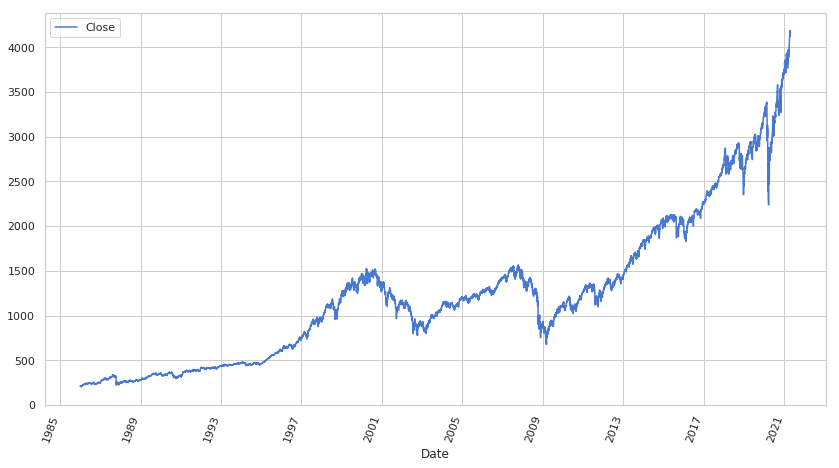

In [8]:
#plot close price 
df.plot()
plt.xticks(rotation = 70)
plt.show()

In [9]:
train_size = int(len(df) * 0.95) #95% of the dataframe will be used for training
test_size = len(df) - train_size #5% of the dataframe will be used for testing
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)] 
print(train.shape, test.shape) 

(8455, 1) (445, 1)


In [10]:
from sklearn.preprocessing import StandardScaler #Import StandardScaler to normalize the price data in the training data

scaler = StandardScaler()
scaler = scaler.fit(train[['Close']]) #We use StandardScaler to learn the properties of the Close column by fitting

train['Close'] = scaler.transform(train[['Close']]) #Transforming the 'Close' column in train data.
test['Close'] = scaler.transform(test[['Close']]) #transforming the 'Close' column in test data.

In [11]:
train.describe()

,Close
count,8.455000e+03
mean,9.412275e-17
std,1.000059e+00
min,-1.359819e+00
25%,-9.785026e-01
50%,-6.165549e-03
75%,4.312987e-01
max,2.789567e+00


In [12]:
test.describe()

,Close
count,445.000000
mean,3.195249
std,0.578139
min,1.642688
25%,2.765445
50%,3.121879
75%,3.591511
max,4.518476


In [13]:
#LSTM Networks require the input data to be in the shape of (n_samples x n_timesteps x n_features)
#n_features = 1 and n_timesteps = 30 (days)

def temporalize(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [14]:
X_train, y_train = temporalize(train[['Close']], train.Close,  30)
X_test, y_test = temporalize(test[['Close']], test.Close, 30)

In [15]:
X_train.shape

(8425, 30, 1)

In [16]:
X_train[:2]

array([[[-1.35081364],
        [-1.34890929],
        [-1.34924884],
        [-1.34459872],
        [-1.35320511],
        [-1.35595089],
        [-1.35617231],
        [-1.35505039],
        [-1.35516849],
        [-1.35277702],
        [-1.35143365],
        [-1.35252606],
        [-1.35385465],
        [-1.35642329],
        [-1.35981859],
        [-1.35869667],
        [-1.35547851],
        [-1.35406132],
        [-1.35048886],
        [-1.34978028],
        [-1.35119745],
        [-1.3475807 ],
        [-1.34436252],
        [-1.34608972],
        [-1.34583875],
        [-1.34508588],
        [-1.3434768 ],
        [-1.34099673],
        [-1.34146914],
        [-1.34139532]],

       [[-1.34890929],
        [-1.34924884],
        [-1.34459872],
        [-1.35320511],
        [-1.35595089],
        [-1.35617231],
        [-1.35505039],
        [-1.35516849],
        [-1.35277702],
        [-1.35143365],
        [-1.35252606],
        [-1.35385465],
        [-1.35642329],
        [

In [17]:
y_train.shape

(8425,)

In [18]:
timesteps = X_train.shape[1] #This is 30 in X_train
n_features = X_train.shape[2] #number of features is 1

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

In [20]:
#Building the LSTM Autoencoder model function
def LSTM_Autoencoder():
    
    model = Sequential()
    model.add(LSTM(
        units=64,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dropout(rate=0.2))
    model.add(RepeatVector(n=X_train.shape[1]))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(rate=0.2))
    model.add(
      TimeDistributed(
        Dense(units=X_train.shape[2])
      )
    )
    model.compile(loss='mae', optimizer='adam')

    return model

In [21]:
model = LSTM_Autoencoder()

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
time_distributed (Tim

In [22]:
#The stopper will stop training when the loss did not decrease for 6 consecutive epochs
ES = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min')
#Model Checkpoint callback. Method used to save the best model observed during training.
MC = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

callbacks_list = [MC]

In [23]:
history = model.fit(X_train, X_train, epochs = 10, batch_size = 32, 
                    validation_split = 0.2, callbacks = callbacks_list, shuffle = False)

Train on 6740 samples, validate on 1685 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
6740/6740 [==============================] - 31s 5ms/sample - loss: 0.1606 - val_loss: 0.3274
Epoch 2/10
6740/6740 [==============================] - 27s 4ms/sample - loss: 0.0815 - val_loss: 0.1902
Epoch 3/10
6740/6740 [==============================] - 27s 4ms/sample - loss: 0.0794 - val_loss: 0.2119
Epoch 4/10
6740/6740 [==============================] - 27s 4ms/sample - loss: 0.0851 - val_loss: 0.1236
Epoch 5/10
6740/6740 [==============================] - 27s 4ms/sample - loss: 0.1159 - val_loss: 0.2667
Epoch 6/10
6740/6740 [==============================] - 27s 4ms/sample - loss: 0.1280 - val_loss: 0.1438
Epoch 7/10
6740/6740 [==============================] - 27s 4ms/sample - loss: 0.1282 - val_loss: 0.2373
Epoch 8/10
6740/6740 [==============================] - 26s 4ms/sample - loss: 0.1272 - val_loss: 0.1892
Epoch 9/10
6740/6740 [==============================] - 27s 4ms/

In [24]:

# demonstrate reconstruction
yhat = model.predict(X_test, verbose=0)
print('---Predicted---')
print(np.round(yhat,3))
print('---Actual---')
print(np.round(X_test, 3))

---Predicted---
[[[2.452]
  [5.104]
  [3.198]
  ...
  [2.886]
  [2.875]
  [2.886]]

 [[2.462]
  [5.127]
  [3.215]
  ...
  [2.912]
  [2.898]
  [2.903]]

 [[2.464]
  [5.13 ]
  [3.217]
  ...
  [2.915]
  [2.901]
  [2.905]]

 ...

 [[3.241]
  [6.571]
  [4.95 ]
  ...
  [4.527]
  [4.551]
  [4.575]]

 [[3.242]
  [6.571]
  [4.952]
  ...
  [4.523]
  [4.548]
  [4.575]]

 [[3.24 ]
  [6.569]
  [4.948]
  ...
  [4.534]
  [4.559]
  [4.583]]]
---Actual---
[[[2.734]
  [2.746]
  [2.777]
  ...
  [2.575]
  [2.603]
  [2.657]]

 [[2.746]
  [2.777]
  [2.797]
  ...
  [2.603]
  [2.657]
  [2.66 ]]

 [[2.777]
  [2.797]
  [2.774]
  ...
  [2.657]
  [2.66 ]
  [2.63 ]]

 ...

 [[4.061]
  [4.095]
  [4.155]
  ...
  [4.518]
  [4.486]
  [4.444]]

 [[4.095]
  [4.155]
  [4.161]
  ...
  [4.486]
  [4.444]
  [4.501]]

 [[4.155]
  [4.161]
  [4.199]
  ...
  [4.444]
  [4.501]
  [4.444]]]


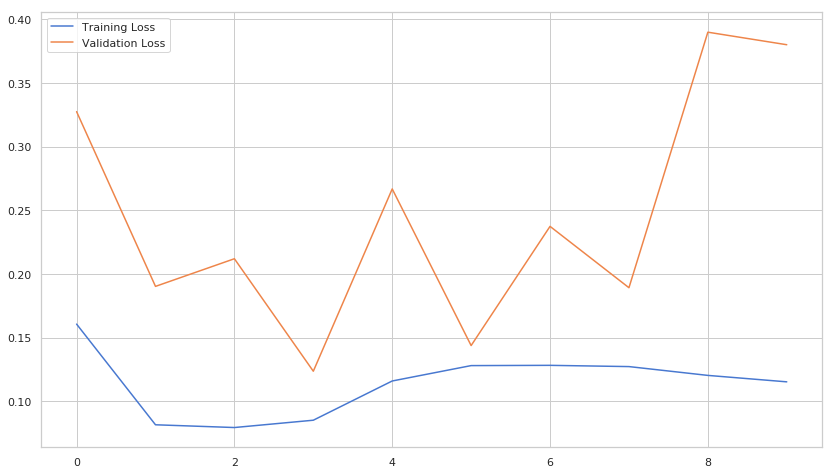

In [25]:
def trainloss_valloss():
    plt.plot(history.history['loss'], label = 'Training Loss') #Plotting training loss
    plt.plot(history.history['val_loss'], label = 'Validation Loss') #Plotting validation loss
    plt.legend() #Using labels as legend
    #If validation loss is lower than Training loss, it means the model is underfitting. 
    #If validation loss is higher than Training loss, it means the model is overfititng
    return plt.show()

trainloss_valloss() 

In [26]:
saved_model = load_model('best_model.h5')

In [27]:
saved_model.evaluate(X_test, X_test)

415/415 [==============================] - 1s 2ms/sample - loss: 0.5581


0.5581015494932612

In [28]:
 

#Predict X_test
X_test_pred = saved_model.predict(X_test)

#Store MAE Loss for test data
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis = 1)

In [29]:
X_train_pred = saved_model.predict(X_train)

In [30]:
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis = 1)

In [31]:
train_mae_loss = train_mae_loss[:,0]

In [32]:
test_mae_loss = test_mae_loss[:,0]

In [33]:
test_mae_loss.shape

(415,)

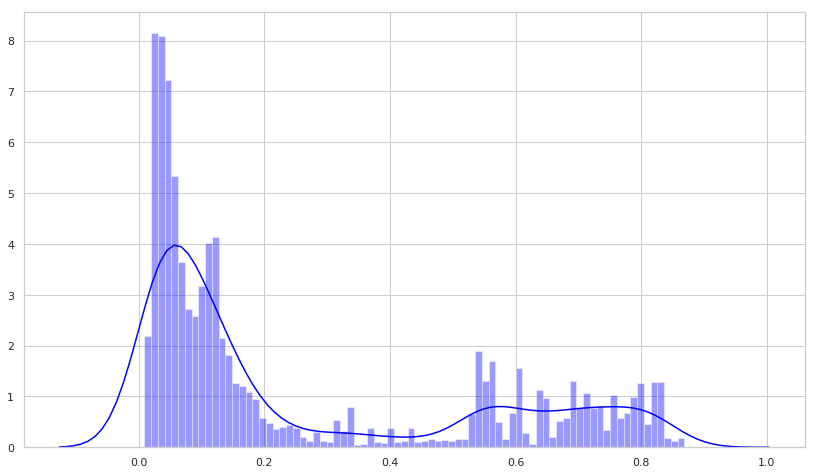

In [34]:
sns.distplot(train_mae_loss,bins=80,kde=True,color='blue')

In [45]:
threshold  = 0.80

In [65]:
#Create DataFrame of losses
test_score_df = pd.DataFrame(test[(timesteps):]) #We use the data that comes after time_steps in test data
test_score_df['loss'] = test_mae_loss #Create test_mae_loss column
test_score_df['threshold'] = threshold #Create threshold column
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold #Set anomaly as True if
test_score_df['Close'] = test[timesteps:].Close


In [66]:
test_score_df.tail()

,Close,loss,threshold,anomaly
Date,,,,
2021-04-19,4.485688,1.324613,0.8,True
2021-04-20,4.443882,1.337944,0.8,True
2021-04-21,4.500687,1.351582,0.8,True
2021-04-22,4.443941,1.364955,0.8,True
2021-04-23,4.510652,1.375155,0.8,True


In [67]:
test_score_df.head()

,Close,loss,threshold,anomaly
Date,,,,
2019-08-30,2.659895,0.251494,0.8,False
2019-09-03,2.630090,0.241254,0.8,False
2019-09-04,2.676606,0.232209,0.8,False
2019-09-05,2.733027,0.219554,0.8,False
2019-09-06,2.737028,0.208010,0.8,False


In [68]:
anomalies = test_score_df[test_score_df.anomaly == True]

In [69]:
anomalies.head()

,Close,loss,threshold,anomaly
Date,,,,
2020-12-10,3.754722,0.808423,0.8,True
2020-12-11,3.747872,0.816628,0.8,True
2020-12-14,3.724297,0.819579,0.8,True
2020-12-15,3.793871,0.824181,0.8,True
2020-12-16,3.803540,0.835341,0.8,True


In [70]:
test_score_df.index

DatetimeIndex(['2019-08-30', '2019-09-03', '2019-09-04', '2019-09-05',
               '2019-09-06', '2019-09-09', '2019-09-10', '2019-09-11',
               '2019-09-12', '2019-09-13',
               ...
               '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15',
               '2021-04-16', '2021-04-19', '2021-04-20', '2021-04-21',
               '2021-04-22', '2021-04-23'],
              dtype='datetime64[ns]', name='Date', length=415, freq=None)

In [71]:
#test_score_df = test_score_df.reset_index()

In [72]:
#test_score_df.Date

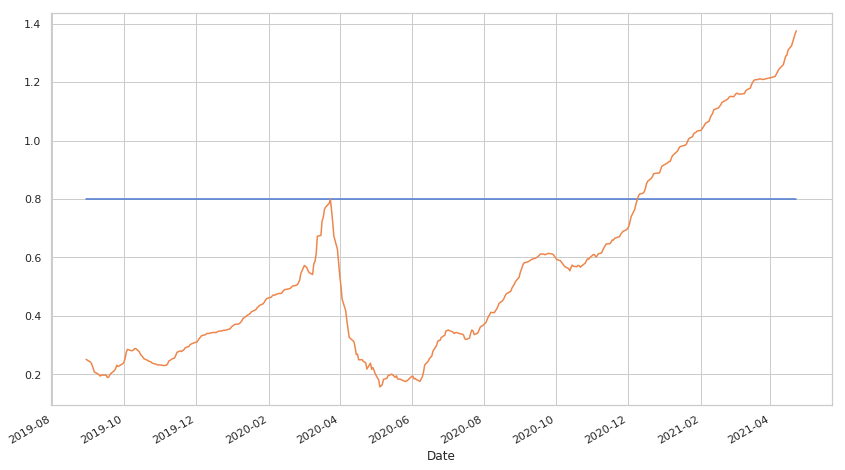

In [74]:
test_score_df.threshold.plot()
test_score_df.loss.plot()